In [1]:
# <!-- collapse=True -->
%matplotlib inline
from datetime import datetime
from IPython.display import Markdown
from os.path import join
from os.path import exists
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

plt.style.use('../big-darkgrid.mplstyle')

# 1. Load the Data

Let's load and examine the ratings data.
From here on until the very end of this project, we want to keep a holdout set that we won't touch except to evaluate a few models we choose based on cross-validation and other metrics.
Here we'll split the data into reviews through 2013 for training and years 2014 and on as our holdout set.
We do this instead of splitting randomly so that we don't get data leakage from the future during model development.
We'll save these files as feather files for fast future loading.

In [2]:
# <!-- collapse=True -->
# This was created in 02_Baselines.ipynb
ratings_through_2013_feather = '../preprocessed/ratings-through-2013.feather'

if exists(ratings_through_2013_feather):
    print("Loading {}".format(ratings_through_2013_feather))
    ratings_df = pd.read_feather(ratings_through_2013_feather)
else:
    raise ValueError("{} doesn't exits. Run 02_Baselines.ipynb to create.")
display(ratings_df.tail())

Loading ../preprocessed/ratings-through-2013.feather


,userId,movieId,rating,timestamp,year,month,day,hour,minute
19153905,120609,81562,3.0,2013-12-31 23:57:27,2013,12,31,23,57
19153906,120609,356,2.5,2013-12-31 23:57:36,2013,12,31,23,57
19153907,120609,74458,4.0,2013-12-31 23:57:47,2013,12,31,23,57
19153908,44501,70533,4.5,2013-12-31 23:58:07,2013,12,31,23,58
19153909,44501,96821,4.0,2013-12-31 23:58:34,2013,12,31,23,58


In [3]:
class DampedUserMovieBaselineModel():
    """Baseline model that of the form mu + b_u + b_i,
    where mu is the overall average, b_u is a damped user
    average rating residual, and b_i is a damped item (movie)
    average rating residual. See eqn 2.1 of
    http://files.grouplens.org/papers/FnT%20CF%20Recsys%20Survey.pdf
    
    Parameters
    ----------
    damping_factor : float, default=0
        Factor to bring residuals closer to 0. Must be positive.
    
    Attributes
    ----------
    mu_ : float
        Average rating over all training samples
    b_u_ : pandas Series, shape = [n_users]
        User residuals
    b_i_ : pandas Series, shape = [n_movies]
        Movie residuals
    damping_factor_ : float, default=0
        Factor to bring residuals closer to 0. Must be positive.
    """
    def __init__(self, damping_factor=0):
        self.damping_factor_ = damping_factor
    
    def fit(self, X, y):
        """Fit training data.
        
        Parameters
        ----------
        X : DataFrame, shape = [n_samples, 2]
            DataFrame with columns 'userId', and 'movieId'
        y : array-like, shape = [n_samples]
            Target values (movie ratings)
        
        Returns
        -------
        self : object
        """
        X = X.copy()
        X['rating'] = y
        self.mu_ = np.mean(y)
        user_counts = X['userId'].value_counts()
        movie_counts = X['movieId'].value_counts()
        b_u = (
            X[['userId', 'rating']]
            .groupby('userId')['rating']
            .sum()
            .subtract(user_counts * self.mu_)
            .divide(user_counts + self.damping_factor_)
            .rename('b_u')
        )
        X = X.join(b_u, on='userId')
        X['movie_residual'] = X['rating'] - X['b_u'] - self.mu_
        b_i = (
            X[['movieId', 'movie_residual']]
            .groupby('movieId')['movie_residual']
            .sum()
            .divide(movie_counts + self.damping_factor_)
            .rename('b_i')
        )
        self.b_u_ = b_u
        self.b_i_ = b_i
        return self
    
    def predict(self, X):
        """Return rating predictions
        
        Parameters
        ----------
        X : DataFrame, shape = [n_samples, 2]
            DataFrame with columns 'userId', and 'movieId'
        
        Returns
        -------
        y_pred : array-like, shape = [n_samples]
            Array of n_samples rating predictions
        """
        X = X.copy()
        X = X.join(self.b_u_, on='userId').fillna(0)
        X = X.join(self.b_i_, on='movieId').fillna(0)
        return self.mu_ + X['b_u'] + X['b_i']

In [4]:
class KNNRecommender():
    def __init__(self, mode='item', k=20, columns=['user', 'item', 'rating'],
                 sparse=False, baseline_algo=None, similarity_func=cosine_similarity):
        if not mode in ['user', 'item']:
            raise ValueError("'mode' must be either 'user' or 'item', not '{}'!".format(mode))
        for col in columns:
            if not col in ['user', 'item', 'rating', 'timestamp']:
                raise ValueError("'{}' is not an acceptable column list entry!".format(col))

        self.mode = mode
        self.k = k
        self.columns = columns
        self.sparse = sparse
        self.baseline_algo = baseline_algo
        self.similarity_func = similarity_func
        
        self.ratings_matrix = None
        self.similarity_matrix = None
        self.train_mean = None
        
        self.column_indices = {col: i for i, col in enumerate(columns)}
        
    def _get_sparse_ratings_matrix(self, X):
        if self.mode == 'item':
            index_col = self.meaning_to_colname_dict['item']
            columns_col = self.meaning_to_colname_dict['user']
        else:
            index_col = self.meaning_to_colname_dict['user']
            columns_col = self.meaning_to_colname_dict['item']
        values_col = self.meaning_to_colname_dict['rating']
        index_map = pd.Series(
            index=np.unique(X[index_col]),
            data=np.arange(X[index_col].nunique()),
            name='index_map',
        )
        columns_map = pd.Series(
            index=np.unique(X[columns_col]),
            data=np.arange(X[columns_col].nunique()),
            name='columns_map',
        )
        X = X.join(index_map, on=index_col).join(columns_map, on=columns_col)
        sparse_matrix = coo_matrix(
            (X[values_col], (X['index_map'], X['columns_map']))
        )
        del X['index_map']
        del X['columns_map']
        sparse_ratings_matrix = pd.SparseDataFrame(sparse_matrix)
        sparse_ratings_matrix.index = index_map.index
        sparse_ratings_matrix.columns = columns_map.index
        return sparse_ratings_matrix
    
    def _get_dense_ratings_matrix(self, X):
        if self.mode == 'item':
            index_col = self.meaning_to_colname_dict['item']
            columns_col = self.meaning_to_colname_dict['user']
        else:
            index_col = self.meaning_to_colname_dict['user']
            columns_col = self.meaning_to_colname_dict['item']
        ratings_matrix = pd.pivot_table(
            data=X,
            values=self.meaning_to_colname_dict['rating'],
            index=index_col,
            columns=columns_col,
        )
        return ratings_matrix
    
    def _get_knn_indices_and_similarities(self, ratings_matrix):
        if self.mode == 'item':
            ratings_matrix = ratings_matrix.T
        n_users_or_items = ratings_matrix.shape[0]
        if self.k > n_users_or_items:
            new_k = n_users_or_items - 1
            print(
                "Warning: k = {} > # {}s = {}! Setting k to {}"
                .format(self.k, n_users_or_items, self.mode, new_k)
            )
            self.k = new_k
        similarity_matrix = self.similarity_func(ratings_matrix)
        np.fill_diagonal(similarity_matrix, -1)
        knn_indices = np.argsort(similarity_matrix, axis=1)[:, ::-1][:, :self.k]
        # https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/neighbors/base.py#L373
        sample_range = np.arange(len(knn_indices))[:, None]
        knn_similarities = similarity_matrix[sample_range, knn_indices]
        return knn_indices, knn_similarities
    
    def fit(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        self.meaning_to_colname_dict = {
            meaning: col for meaning, col in zip(self.columns, X.columns)
        }
        if self.baseline_algo is None:
            self.train_mean = X['rating'].mean()
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.fit(X).predict(X)
        X['rating'] -= X['rating_baseline']
        if self.sparse:
            ratings_matrix = self._get_sparse_ratings_matrix(X)
        else:
            ratings_matrix = self._get_dense_ratings_matrix(X)
        ratings_matrix = ratings_matrix.fillna(0)
        self.knn_indices, self.knn_similarities = self._get_knn_indices_and_similarities(ratings_matrix)
        return self

    def predict(self, X):
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a DataFrame")
        X = X.copy()
        if self.baseline_algo is None:
            X['rating_baseline'] = self.train_mean
        else:
            X['rating_baseline'] = self.baseline_algo.predict(X)
        X['rating'] -= X['rating_baseline']
        # TODO: Finish predict function

In [5]:
sparse_times = []
dense_times = []
matrix_sizes = []
n_ratings_list = [20000, 50000, 100000, 200000, 500000, 1000000]
k = 20

for n_ratings in n_ratings_list:
    print("Using {} ratings with dense ratings matrix".format(n_ratings))
    t1 = datetime.now()
    rec = KNNRecommender(mode='user', k=k, sparse=False)
    rec.fit(ratings_df[:n_ratings])
    t2 = datetime.now()
    dt = t2 - t1
    full_ratings_matrix_size = sys.getsizeof(rec.knn_similarities) * len(rec.knn_similarities) / k
    dense_times.append(dt.total_seconds())
    matrix_sizes.append(full_ratings_matrix_size)
    
for n_ratings in n_ratings_list:
    print("Using {} ratings with sparse ratings matrix".format(n_ratings))
    t1 = datetime.now()
    rec = KNNRecommender(mode='user', k=k, sparse=True)
    rec.fit(ratings_df[:n_ratings])
    t2 = datetime.now()
    dt = t2 - t1
    sparse_times.append(dt.total_seconds())

Using 20000 ratings with dense ratings matrix
Using 50000 ratings with dense ratings matrix
Using 100000 ratings with dense ratings matrix
Using 200000 ratings with dense ratings matrix
Using 500000 ratings with dense ratings matrix
Using 1000000 ratings with dense ratings matrix
Using 20000 ratings with sparse ratings matrix
Using 50000 ratings with sparse ratings matrix
Using 100000 ratings with sparse ratings matrix
Using 200000 ratings with sparse ratings matrix
Using 500000 ratings with sparse ratings matrix
Using 1000000 ratings with sparse ratings matrix


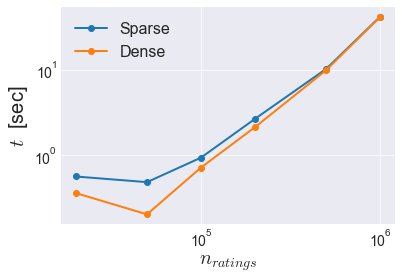

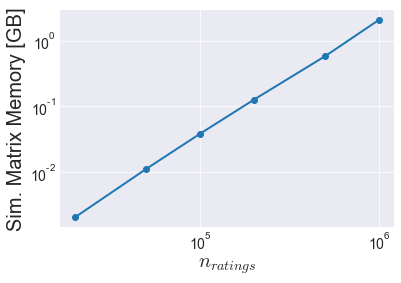

In [9]:
plt.loglog(n_ratings_list, sparse_times, 'o-', label='Sparse')
plt.loglog(n_ratings_list, dense_times, 'o-', label='Dense')
plt.ylabel(r'$t$  [sec]')
plt.xlabel(r'$n_{ratings}$')
plt.legend()
plt.show()
plt.loglog(n_ratings_list, np.array(matrix_sizes)/(2**30), 'o-')
plt.xlabel(r'$n_{ratings}$')
plt.ylabel('Sim. Matrix Memory [GB]')
plt.show()